In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [118]:
naver_review = pd.read_csv("Movie.csv")
imdb_review = pd.read_csv("reviews_imdb.csv")

In [119]:
# Datetime 전환 / 리뷰 레이팅만 따로 뽑기 / NA 데이터 제외
naver_review["star_rating"] = naver_review["star_rating"].apply(lambda x: int(x[12:]))
naver_review["writing_date"] = pd.to_datetime(naver_review["writing_date"]).dt.date

naver_review['comment'] = naver_review['comment'].str.replace(r"[^0-9ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True)
naver_review.replace({'comment': {'': np.nan}}, inplace=True)

naver_review = naver_review.dropna(how = 'any')

keywords = ["19세", "관람가", "15세", "19금", "15", "부모님", "아이", "등급",
            "어린이", "학생", "애들", "아들", "딸", "자녀", "수위", "가족끼리", "가족이랑"]

def label_age_related(text: str, kw_list: list) -> int:
    for kw in kw_list:
        if kw in text:
            return 1
    return 0
naver_review['label_age'] = naver_review['comment'].apply(lambda x: label_age_related(x, keywords))

imdb_review = imdb_review.dropna(how = 'any')
imdb_review['writing_date'] = pd.to_datetime(imdb_review['date']).dt.date

naver_review['source'] = 'naver(KOR)'
imdb_review['source'] = 'imdb(US)'

In [86]:
# imdb_review = imdb_review.dropna(how = 'any')

# def summarize_reviews(reviews):
#     summarized_reviews = []

#     for review in reviews:
#         sentences = re.split(r'[.!?]', review)
#         sentences = [s.strip() for s in sentences if s.strip()]

#         if len(sentences) > 3:
#             first_sentence = sentences[0].strip()
#             second_sentence = sentences[1].strip()
#             third_sentence = sentences[2].strip()

#             if len(first_sentence) + len(second_sentence) + len(third_sentence) > 450:
#                 sliced_review = f"{first_sentence}. {second_sentence}".strip()
#             else:
#                 sliced_review = f"{first_sentence}. {second_sentence}. {third_sentence}".strip()
#         else:
#             sliced_review = '. '.join([s.strip() for s in sentences if s.strip()])

#         if not sliced_review.endswith('.'):
#             sliced_review += '.'
#         summarized_reviews.append(sliced_review)

#     return summarized_reviews

# imdb_review["content"] = summarize_reviews(imdb_review["content"])

In [90]:
imdb_review['content'][8]

"Saw Parasite yesterday. Something that we missed out during MAMI. What a brilliant gripping tale this is! It is a class-conscious thriller that you wouldn't want to miss.\n\nTo start with, it makes you laugh with its comic rendering. When you see the entire movie it defies all your expectations along the line. Bong Joon-ho crafts an intricate look at modern-day social hierarchies. He keeps you flipped on one mood then drastically changes it to the other while delivering some brilliant thematic elements. When you spend 132 minutes seeing this movie you encounter and experience: clever, humorous, dramatic and every other kind of emotion.\n\nIt is also a hilarious and irreverent take on South Korea's class warfare. I cannot overstate how refreshing Parasite is both as a genius piece of arthouse cinema, but also a very contemporary comedy of errors. Parasite is so sublime because it can be watched for pure entertainment value of a sly poor family manipulating gullible elites into paying t

In [91]:
total_reviews = imdb_review['content'].tolist() + naver_review['comment'].tolist()
total_ratings = imdb_review["star_rating"].tolist() + naver_review["star_rating"].tolist()

In [92]:
import torch
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util

model_name = 'sentence-transformers/distiluse-base-multilingual-cased-v2'
model = SentenceTransformer(model_name)

batch_size = 64
embeddings = []

for i in tqdm(range(0, len(total_reviews), batch_size)):
    batch = total_reviews[i:i + batch_size]
    batch_embeddings = model.encode(batch, convert_to_numpy=True)
    embeddings.append(batch_embeddings)

embeddings = np.vstack(embeddings)

100%|██████████| 64/64 [09:06<00:00,  8.54s/it]


In [97]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

num_pca_components = 31
pca = PCA(n_components=num_pca_components, random_state=42)
embeddings_reduced = pca.fit_transform(embeddings)

scaler = MinMaxScaler()
ratings_scaled = scaler.fit_transform(np.array(total_ratings).reshape(-1, 1))

agg_features = np.hstack([embeddings_reduced, ratings_scaled])

num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(agg_features)

cluster_labels = kmeans.labels_
for sent, lbl in list(zip(total_reviews, cluster_labels))[-40:-20]:
    print(f"문장: {sent}, 클러스터: {lbl}")

c:\Users\Shon\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


문장: 쓰레기영화더러운감성을포장한변태적인생각과 감성을 외국에서 상받았으니 좋다고 해야하나, 클러스터: 1
문장: 계급 우화니 미장센이니 일단 스토리가 재밌다, 클러스터: 0
문장: 난 내가 영화속 삶의 기생충같았다슬펐다계속 변화없는 삶이될까 슬펐다, 클러스터: 0
문장: 이 영화를 보고 봉준호감독님 팬 됐습니다, 클러스터: 0
문장: 대작영화 다만 쇼파씬ㅜ가족끼리보다가 짜증나고 민망했다, 클러스터: 0
문장: 난 홍대병이 있어서 그런가 상도 받고 워낙 많은 사람들이 보고 칭찬해서 안보다가 우연한 기회에 보게되었는데 잘 만들었더라 영화 자체가 빈부격차라는 소재를 정말 극명하고 와닿게 드러내는 느낌에 결말까지 완벽한 느낌 평소 살아가면서 쉽게 느끼, 클러스터: 0
문장: 중반부까지는 재미있었지만 후반부는 너무 징그럽고 끔직함 이걸 왜 15세로 해뒀는지 모르겠는 영화, 클러스터: 1
문장: 가족은 위대했다 가족의 힘을 보여준 영화, 클러스터: 0
문장: 왜 오늘이 이른지 삶이 힘겹다면 깊게 한 숨을 내쉬어 보길바래 당신에게 전하는 위로 또는 위안, 클러스터: 0
문장: 봉준호 감독의 장점을 잘 볼 수 있는 영화, 클러스터: 0
문장: 봉준호 감독이 생각하는 사회의 메세지를 희극한 영화 하지만 극장에서 가족끼리 볼 영화는 아니다 차라리 날선 비판을 담아내어 독립영화로 출품했어야 한다, 클러스터: 1
문장: 3번째 감상에서 얼마나 위대한 스토리였는가 깨닫는다취업의 순서도 마치 작은 사슬이 큰 사슬로 타고 올라가듯 가장 월급이 작은 사람부터 많은 사람으로, 클러스터: 0
문장: 지하에서 어지간해서는 나올수 없는 사회 무계획이 최고의 계획이라는 멘트봉준호 감독님 짱, 클러스터: 0
문장: 기대하고 봤음에도 제 생각에는 최고의 한국 영화 중 한 편이 아닐까 싶습니다, 클러스터: 0
문장: 지하통로 나오기전까진 너무 흥미진진그후는 너무 씁쓸, 클러스터: 0
문장: 200211끝끝내 취할 수 없었던 죽을때까지 남의 삶일 것을욕심부려봤자 비참할 뿐이지, 클러스터: 0
문장: 재미

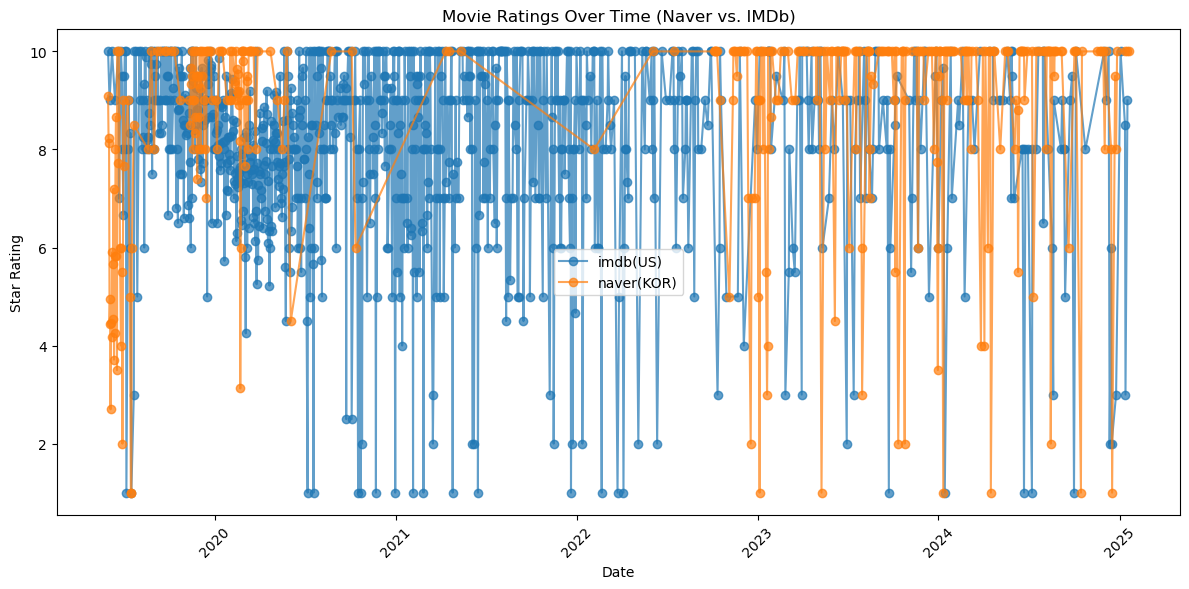

In [123]:
selected_naver = naver_review[['writing_date', 'star_rating', 'source']]
selected_imdb = imdb_review[['writing_date', 'star_rating', 'source']]

merged_reviews = pd.concat([selected_naver, selected_imdb])

daily_avg_ratings = merged_reviews.groupby(['writing_date', 'source'])['star_rating'].mean().reset_index()
daily_avg_ratings = daily_avg_ratings.sort_values('writing_date')

plt.figure(figsize=(12, 6))
for source, data in daily_avg_ratings.groupby('source'):
    data = data.sort_values('writing_date')
    plt.plot(
        data['writing_date'],
        data['star_rating'],
        marker='o',
        label=source,
        alpha=0.7
    )

plt.xlabel("Date")
plt.ylabel("Star Rating")
plt.title("Movie Ratings Over Time (Naver vs. IMDb)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()